In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy import stats
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, get_scorer
from sklearn.model_selection import KFold, RepeatedKFold, GridSearchCV, cross_validate, train_test_split

In [ ]:
# Use house pricing data (price vs. area) from Kaggle

from google.colab import files
from google.colab import drive

uploaded = files.upload()

Saving Housing.csv to Housing.csv


In [ ]:
dataset= pd.read_csv("Housing.csv")

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
scaler = MinMaxScaler()

# Train test split
from sklearn.model_selection import train_test_split

#Splitting into Training and Testing sets
df_train, df_test = train_test_split(dataset, train_size = 0.7, test_size = 0.3, random_state = 100)

#Numeric Columns
num_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking','price']

#scaling training and test data INDIVIDUALLY
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_test[num_vars] = scaler.fit_transform(df_test[num_vars])

#getting columns that don't have a numeric value
string_columns = [x for x in df_train.columns.tolist() if x not in num_vars]

#Encoding Labels into numeric values
df_train = pd.get_dummies(df_train, columns=string_columns, prefix=string_columns)
df_test = pd.get_dummies(df_test, columns=string_columns, prefix=string_columns)


In [ ]:
#Splitting Training data into X and Y
X_train = df_train.drop('price', axis = 1)
Y_train = df_train['price']

#Splitting Test data into X and Y
X_test = df_test.drop('price', axis = 1)
Y_test = df_test['price']

In [ ]:
# solve a prediction/ forecasting problem using linear regression
from sklearn.linear_model import LinearRegression

#Fitting To a Linear Regression model
lm = LinearRegression(fit_intercept=True)
lm.fit(X_train, Y_train)

#Predicted Values from Linear Regression
training_predictions = lm.predict(X_train)
test_predictions = lm.predict(X_test)


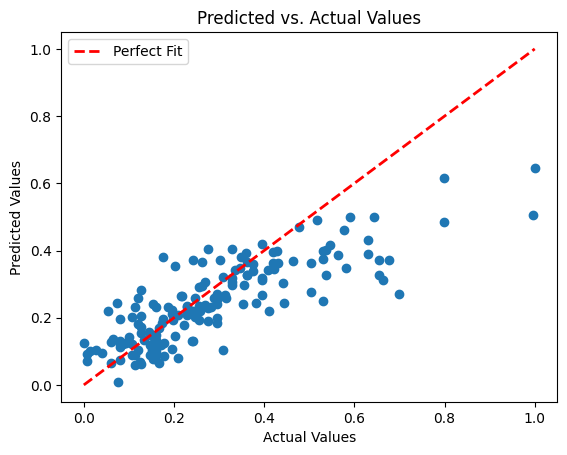

In [ ]:
# visualize results (plots)
fig = plt.figure()
plt.scatter(Y_test,test_predictions)
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', linestyle='--', linewidth=2, label='Perfect Fit')

plt.title('Predicted vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

In [ ]:
# Cross validation
from sklearn.model_selection import cross_val_score, KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = cross_val_score(lm, X_test, Y_test, cv=kf, scoring='neg_mean_squared_error')

average_mse = abs(mse_scores).mean()
print(average_mse)

0.013801273277568499


0.599557533872853


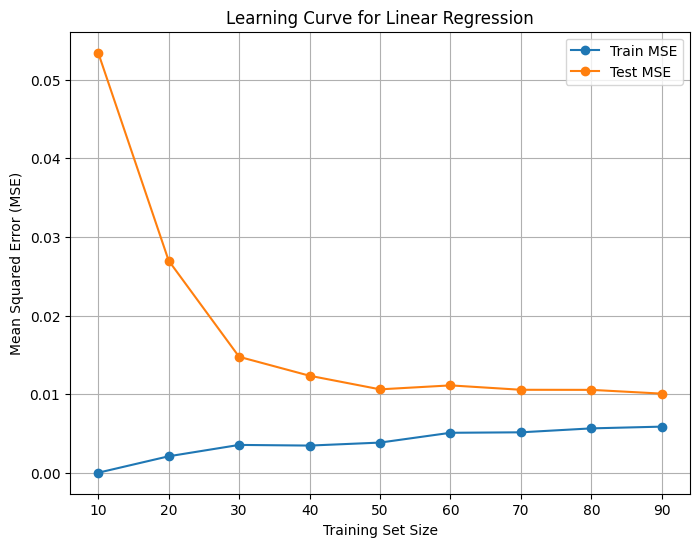

In [ ]:
# accuracy of results (R^2 score, mean absolute and mean squared errors, learning curves)
from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve

# A higher R2 value (closer to 1) indicates better model fit.
r2=r2_score(Y_test, test_predictions)
print(r2)

#learning curve
model = LinearRegression()
train_sizes = [10, 20, 30, 40, 50, 60, 70,80, 90]
train_sizes, train_mse, test_mse = learning_curve(model, X_train, Y_train, train_sizes=train_sizes, cv=kf, scoring='neg_mean_squared_error')
train_mse = -np.mean(train_mse, axis=1)
test_mse = -np.mean(test_mse, axis=1)
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mse, label='Train MSE', marker='o')
plt.plot(train_sizes, test_mse, label='Test MSE', marker='o')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Learning Curve for Linear Regression')
plt.legend()
plt.grid(True)
model.fit(X_train, Y_train)
plt.show()

In [ ]:
# Bias variance tradeoff for l1- regularized regression with scikit-learn
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

Lasso = Lasso(alpha = 0.01,fit_intercept = True)

Lasso.fit(X_train, Y_train)

L1_predict_train = Lasso.predict(X_train)
L1_predict_test = Lasso.predict(X_test)

mse_L1_train = mean_squared_error(Y_train, L1_predict_train)
mse_L1_test = mean_squared_error(Y_test, L1_predict_test)

print(mse_L1_test)

0.022693607848993498


In [ ]:
#function to plot scorer vs alpha_parameter
def regmodel_param_plot(
    validation_score, train_score, alphas_to_try, chosen_alpha,
    scoring, model_name, test_score = None):

    plt.figure(figsize = (8,8))
    sns.lineplot(y = validation_score, x = alphas_to_try,
                 label = 'validation_data')
    sns.lineplot(y = train_score, x = alphas_to_try,
                 label = 'training_data')
    plt.axvline(x=chosen_alpha, linestyle='--')
    if test_score is not None:
        sns.lineplot(y = test_score, x = alphas_to_try,
                     label = 'test_data')
    plt.xlabel('alpha_parameter')
    plt.ylabel(scoring)
    plt.title(model_name + ' Regularisation')
    plt.legend()
    plt.show()

In [ ]:
#Change scoring from 'r2' to 'neg_mean_squared_error' if needed
def regmodel_param_test(alphas_to_try, X, y, cv, scoring, model_name, X_test = None, y_test = None, draw_plot = False):

    validation_scores = []
    train_scores = []
    results_list = []

    if X_test is not None:
        test_scores = []
        scorer = get_scorer(scoring)
    else:
        test_scores = None

    #Loop through alpha values in alphas_to_try
    for curr_alpha in alphas_to_try:
        if model_name == 'LASSO':
            regmodel = Lasso(alpha = curr_alpha)  #set model as Lasso w/ alpha = curr_alpha

        results = cross_validate(regmodel, X, y, scoring=scoring, cv=cv, return_train_score = True)    #cross_validate model

        validation_scores.append(np.mean(results['test_score'])) #append mean test_score into validation_scores
        train_scores.append(np.mean(results['train_score'])) #append mean train scores into train_scores
        results_list.append(results) #append results from cross-validation into results_list

        if X_test is not None:
            regmodel.fit(X,y) #fit model to X and y
            y_pred = regmodel.predict(X_test) #get y predictions
            test_scores.append(scorer(regmodel, X_test, y_test)) #get test score

    chosen_alpha_id = np.argmax(validation_scores) #get alpha_id that matches with best(max) validation score in validation_scores list
    chosen_alpha = alphas_to_try[chosen_alpha_id] #get best alpha from alpha_id
    max_validation_score = np.max(validation_scores) #get best(max) validation score

    if X_test is not None:
        test_score_at_chosen_alpha = test_scores[chosen_alpha_id] #get corresponsing test scores
    else:
        test_score_at_chosen_alpha = None

    #if draw_plot = True, plot
    if draw_plot:
        regmodel_param_plot(
            validation_scores, train_scores, alphas_to_try, chosen_alpha,
            scoring, model_name, test_scores)

    return chosen_alpha, max_validation_score, test_score_at_chosen_alpha

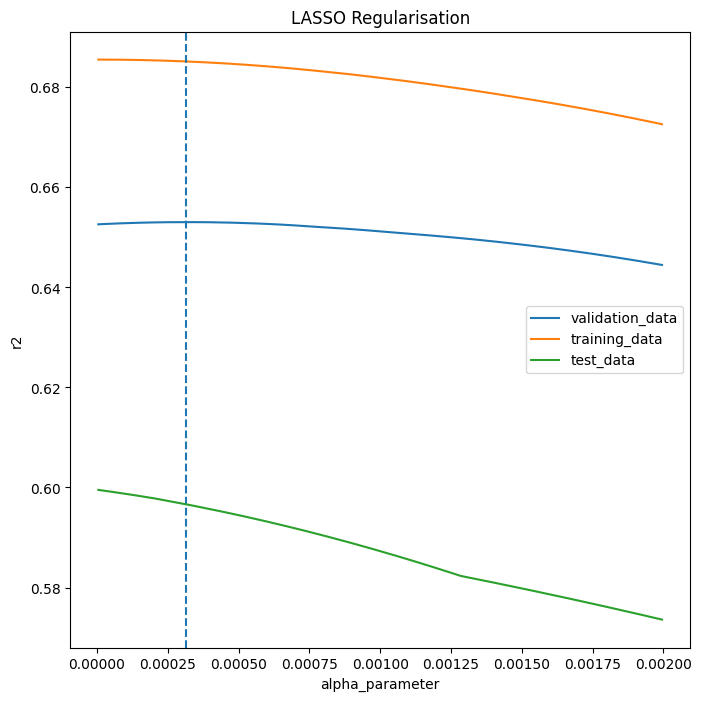

In [ ]:
#Hyperparameter tuning: Best alpha using R2 score
from sklearn.linear_model import Lasso
alphas = [x/200000 for x in range(1,400)]
best_alpha_R2, max_val_score_R2, test_score_R2 = regmodel_param_test(alphas, X_train, Y_train, None, 'r2', 'LASSO', X_test, Y_test, True)

In [ ]:
print(f'Best alpha score: {best_alpha_R2}\nBest validation set R2: {max_val_score_R2}\nTest R2 score: {test_score_R2}')

Best alpha score: 0.000315
Best validation set R2: 0.6530345794862715
Test R2 score: 0.5966381824981533


In [ ]:
#Hyperparameter tuning for L1 reg using GridSearchCV:
from sklearn.linear_model import Lasso
Lasso = Lasso()

# Perform grid search over range of alphas
param_grid = {'alpha':[x/200000 for x in range(1,400)]}
grid_search = GridSearchCV(estimator = Lasso, param_grid=param_grid, cv=5)
grid_search.fit(X_train, Y_train)

# Get the best alpha
best_alpha = grid_search.best_params_['alpha']
print(f'GridSearchCV Best alpha score : {best_alpha}')

GridSearchCV Best alpha score : 0.000315


In [ ]:
#Gather data to plot alpha vs MSE & alpha vs R2
alpha_dict={}
alpha_dict['alpha']=[]
alpha_dict['training mse']=[]
alpha_dict['test mse']=[]
alpha_dict['training R2']=[]
alpha_dict['test R2']=[]

for x in range(0,400):
  from sklearn.linear_model import Lasso
  Lasso = Lasso(alpha = x/10000,fit_intercept = True)

  Lasso.fit(X_train, Y_train)

  L1_predict_train = Lasso.predict(X_train)
  L1_predict_test = Lasso.predict(X_test)

  mse_L1_train = mean_squared_error(Y_train, L1_predict_train)
  mse_L1_test = mean_squared_error(Y_test, L1_predict_test)
  r2_L1_train = r2_score(Y_train, L1_predict_train)
  r2_L1_test = r2_score(Y_test, L1_predict_test)

  alpha_dict['alpha'].append(x/10000)
  alpha_dict['training mse'].append(mse_L1_train)
  alpha_dict['test mse'].append(mse_L1_test)
  alpha_dict['training R2'].append(r2_L1_train)
  alpha_dict['test R2'].append(r2_L1_test)

<ipython-input-18-ed31a6f53d44>:13: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  Lasso.fit(X_train, Y_train)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.503e+00, tolerance: 9.439e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


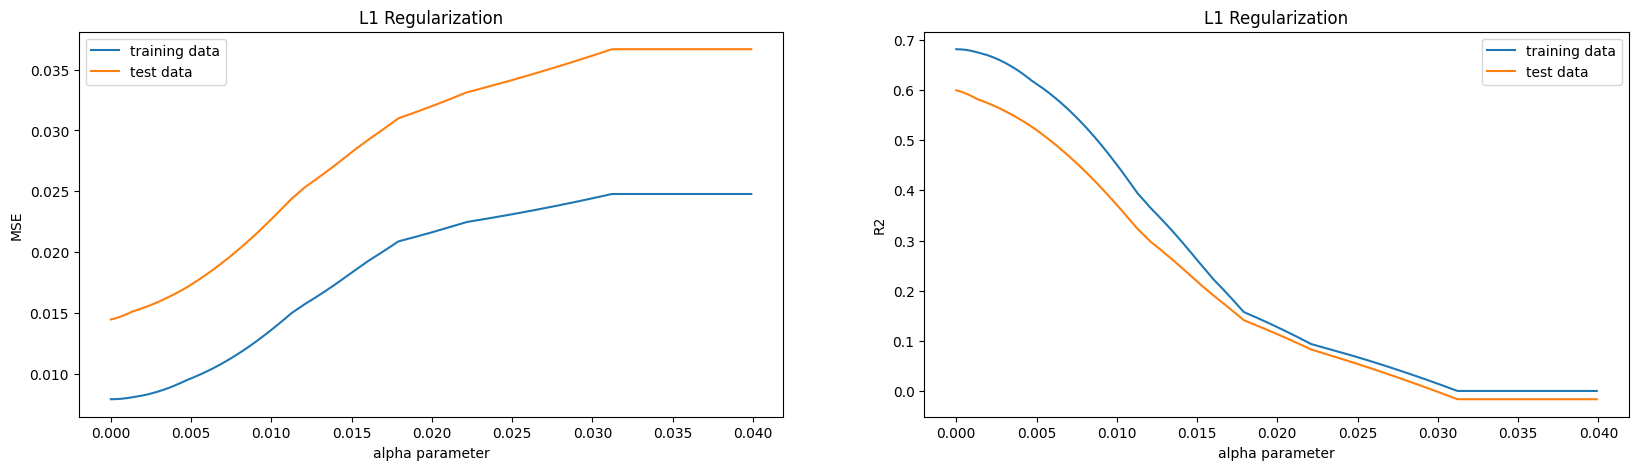

In [ ]:
#Visualize alpha-tuning for L1 regularization
fig, ax =plt.subplots(1,2,figsize=(20,5))

sns.lineplot(data=alpha_dict, x='alpha',y='training mse',label='training data',ax=ax[0])
sns.lineplot(data=alpha_dict, x='alpha',y='test mse',label='test data',ax=ax[0])
sns.lineplot(data=alpha_dict, x='alpha',y='training R2',label='training data',ax=ax[1])
sns.lineplot(data=alpha_dict, x='alpha',y='test R2',label='test data',ax=ax[1])
ax[0].set_xlabel('alpha parameter')
ax[0].set_ylabel('MSE')
ax[0].set_title('L1 Regularization')
ax[0].legend()

ax[1].set_xlabel('alpha parameter')
ax[1].set_ylabel('R2')
ax[1].set_title('L1 Regularization')
ax[1].legend()
fig.show()

In [ ]:
#MEAN Squared Error
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(Y_test, test_predictions)

print(mse)

0.014451840099238335


In [ ]:
# hyper parameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

alpha_values = [0.001, 0.01, 0.1, 1, 10, 100]
param_grid = {'alpha': alpha_values}

lasso = Lasso()
grid_search = GridSearchCV(lasso, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, Y_train)
best_alpha = grid_search.best_params_['alpha']

# Train a Lasso model with the best hyperparameters on the entire training set
best_lasso_model = Lasso(alpha=best_alpha)
best_lasso_model.fit(X_train, Y_train)

# Evaluate the best model on the test set
test_score = best_lasso_model.score(X_test, Y_test)

print(f"Best Alpha: {best_alpha}")
print(f"Test Score (R-squared): {test_score}")

# Which hyperparameters for linear regression you can tune in Python’s scikit-learn module and how?
#They are fit_intercept and normalization, alphas? You can use GridSearchCV

Best Alpha: 0.001
Test Score (R-squared): 0.5872829215992501


Text(0, 0.5, 'Objective function')

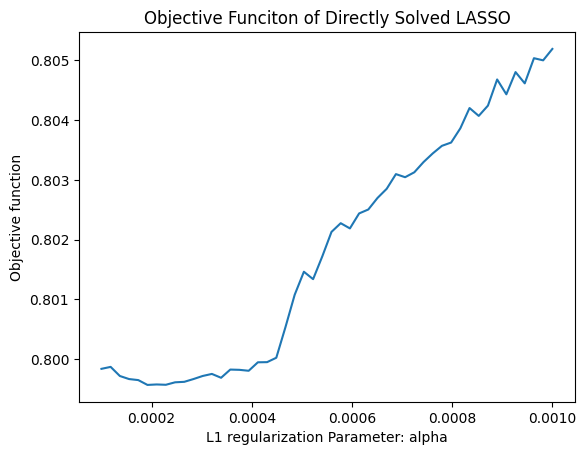

In [ ]:
###Manual Lasso Calulation

##This cell aims to perform LASSO optimization directly as opposed to using the built in scikit learn model

#objective: minimize (1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1
#where y is the predicted value, X is the matrix coefficients, W is the weight of each feature, alpha is the hyper parameter
num_iterations = 1000

def Direct_lasso(alpha, num_iterations, X, Y):
  w = np.zeros(X.shape[1])
  learning_rate = 0.1
  for i in range(num_iterations):
      # Compute the gradient
      residuals = Y - np.dot(X, w)
      gradient = -np.dot(X.T, residuals) / len(Y) + alpha * np.sign((w))

      #Compute Coefficients
      w -= learning_rate * gradient
  return w


alphas = np.linspace(0.0001,0.001,50)

objective_vals = []
for a in alphas:
  #split and shuffle data at each iteration
  X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

  #Compute Coefficients
  w = Direct_lasso(a, num_iterations, X_train2, Y_train2)

  #Compute objective function
  J = np.sum((Y_test2 - np.dot(X_test2, w))**2) + a*np.sum(abs(w))
  objective_vals.append(J)
  # print(a, J)

plt.plot(alphas, objective_vals)
plt.title('Objective Funciton of Directly Solved LASSO')
plt.xlabel('L1 regularization Parameter: alpha')
plt.ylabel('Objective function')

In [ ]:
#Used to normalize array for the purpose of plotting them together
def min_max_scaling(arr):
    min_val = np.min(arr)
    max_val = np.max(arr)
    scaled_arr = (arr - min_val) / (max_val - min_val)
    return scaled_arr

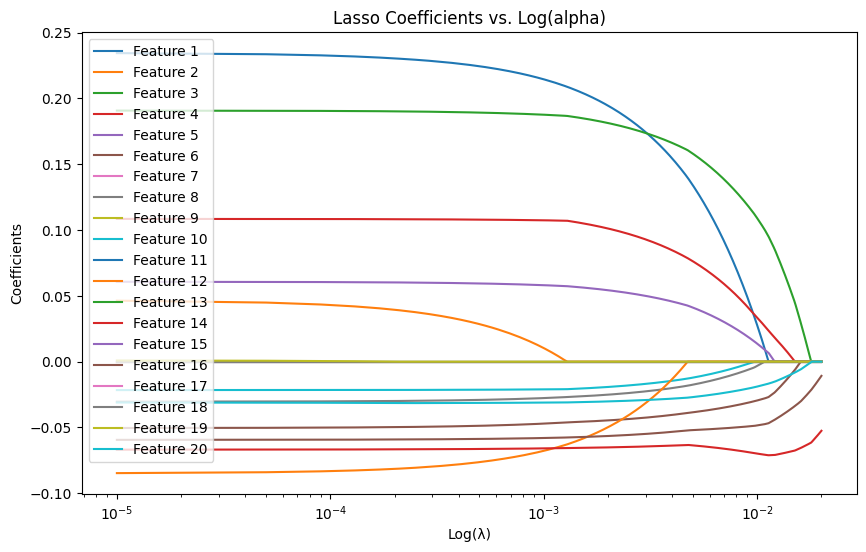

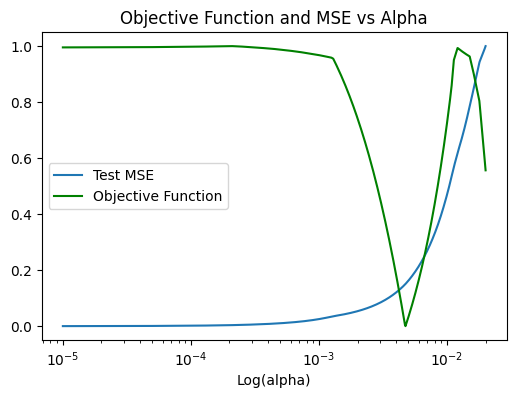

In [ ]:
##This cell visualizes how the L1 regularization parameter changes the coefficients of the model

from sklearn.linear_model import LassoCV
from mlxtend.evaluate import bias_variance_decomp
model = LassoCV(cv=5)
model.fit(X_train, Y_train)
alphas = np.linspace(0.00001,0.02,500)

# Plotting the coefficients vs. λ
# alphas = model.alphas_
coefs = []
mses = []
Objs = []
mse_trains = []
J_trains = []
bias_values = []
variance_values = []

def objective_function(y_true, y_pred):
  mse_loss = mean_squared_error(y_true, y_pred)
  l1_regularization = a * np.sum(np.abs(lasso.coef_))
  return mse_loss * len(y_true) + l1_regularization

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, Y_train)
    y_pred = lasso.predict(X_test)
    mse_train = mean_squared_error(Y_train, lasso.predict(X_train))
    mse = mean_squared_error(Y_test, y_pred)
    w = lasso.coef_
    J = np.sum((Y_test - np.dot(X_test, w))**2) + a*np.sum(abs(w))
    J_train = np.sum((Y_train - np.dot(X_train, w))**2) + a*np.sum(abs(w))

    mses.append(mse)
    coefs.append(w)
    Objs.append(J)
    mse_trains.append(mse_train)
    J_trains.append(J_train)
    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(lasso, np.array(X_train), np.array(Y_train), np.array(X_test), np.array(Y_test), loss='mse', random_seed=42)
    bias_values.append(avg_bias)
    variance_values.append(avg_var)



plt.figure(figsize=(10, 6))
for i in range(X_train.shape[1]):
    plt.plot(alphas, [coef[i] for coef in coefs], label=f'Feature {i+1}')

plt.xscale('log')
plt.xlabel('Log(λ)')
plt.ylabel('Coefficients')
plt.title('Lasso Coefficients vs. Log(alpha)')
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.xscale('log')
plt.plot(alphas, min_max_scaling(mses), label='Test MSE')
plt.xlabel('Log(alpha)')
plt.title('Objective Function and MSE vs Alpha')
plt.plot(alphas, min_max_scaling(Objs),color='g', label='Objective Function')
plt.legend()
plt.show()

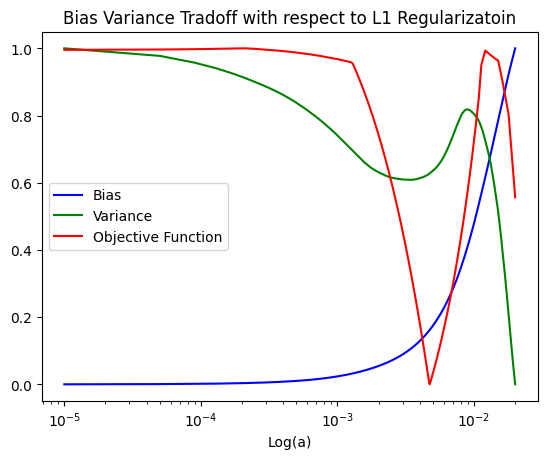

In [ ]:
##This cell visualizes the Bias Variance tradeoff with respect to the L1 regularization parameter

#Scale the bias, variance, and Objective function so it can be clearly shown on a single graph.
Bias_scaled = min_max_scaling(bias_values)
Varience_scaled = min_max_scaling(variance_values)
Objetive_scaled = min_max_scaling(Objs)

plt.xscale('log')
# plt.plot(alphas, min_max_scaling(mses), color='orange' ,label='Test MSE', lw=4)
plt.plot(alphas, Bias_scaled, label='Bias', color='blue')
plt.plot(alphas, Varience_scaled, label='Variance', color = 'green')
plt.plot(alphas, Objetive_scaled,color='red', label='Objective Function')

plt.title('Bias Variance Tradoff with respect to L1 Regularizatoin')
plt.xlabel('Log(a)')
plt.legend()
